# Circular Separability

CSI4106 Introduction to Artificial Intelligence

Marcel Turcotte (School of Electrical Engineering and Computer Science,
University of Ottawa)  
2025-10-17

## Data

During the lecture, I recommended using [TensorFlow
Playground](https://playground.tensorflow.org) as an interactive tool to
deepen your intuitive grasp of neural networks and machine learning
principles. In particular, I advised experimenting with the dataset
comprising an inner circle (class 1) and an outer ring (class 0). This
notebook offers a more detailed exploration of these concepts.

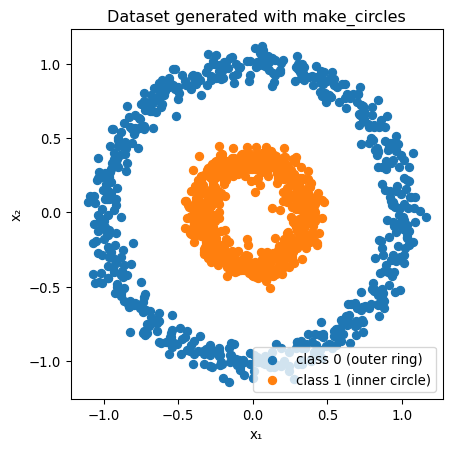

In [1]:
# Generate and plot the "circles" dataset
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

# Generate synthetic data
X, y = make_circles(n_samples=1200, factor=0.35, noise=0.06, random_state=42)

# Separate coordinates for plotting
x1, x2 = X[:, 0], X[:, 1]

# Plot the two classes
plt.figure(figsize=(5, 5))
plt.scatter(x1[y==0], x2[y==0], color="C0", label="class 0 (outer ring)")
plt.scatter(x1[y==1], x2[y==1], color="C1", label="class 1 (inner circle)")
plt.xlabel("x₁")
plt.ylabel("x₂")
plt.title("Dataset generated with make_circles")
plt.axis("equal") # ensures circles look round
plt.legend()
plt.show()

Clearly, this dataset is not linearly separable in $(x_1, x_2)$!

## Feature engineering

When using a linear classifier like
[`LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html),
it is not possible to derive parameters that enable accurate
classification of the given examples.

In TensorFlow Playground, users can incorporate two additional features,
$x_1^2$ and $x_2^2$. This allows for the classification of examples
using a straightforward network configuration with no hidden layers and
a single output node. When employing the sigmoïd function as the
activation, this setup effectively functions as logistic regression.
However, the feature space becomes four-dimensional, complicating direct
visualization.

In this notebook, we introduce a single feature specifically designed to
facilitate visualization. $$
r = x_1^2 + x_2^2,
$$ **(r)** represents the **squared distance from the origin** —
essentially the **radius squared** in polar coordinates.

### Intuition

-   Each point in the original 2-D plane has coordinates $(x_1, x_2)$.
-   If you express those same coordinates in polar form, you have

$$
  x_1 = r^{1/2} \cos\theta, \quad x_2 = r^{1/2} \sin\theta,
$$ or more conventionally, $r_{\text{polar}} = \sqrt{x_1^2 + x_2^2}$.

-   Here, we define $r = x_1^2 + x_2^2$, i.e., the **square** of that
    radius.

Using $r$ instead of $\sqrt{r}$ keeps the mapping differentiable and
avoids square roots in the model.

### Why it’s useful

In the “circle vs. ring” dataset:

-   Points from the **inner circle** are close to the origin, small $r$.
-   Points from the **outer ring** are farther away, large $r$.

Thus, the problem that is **non-linear** in $(x_1, x_2)$ becomes
**linearly separable** in $r$:

$$
\text{inner if } r < r^*, \quad \text{outer if } r > r^*.
$$

So $r$ is a **feature encoding the radial distance**, allowing a linear
model like logistic regression to separate the classes with a single
threshold in 1-D.

## 3D view

$(x_1,x_2,r)$ with $r=x_1^2+x_2^2$

In [2]:
import numpy as np
from sklearn.datasets import make_circles
from sklearn.linear_model import LogisticRegression
import plotly.graph_objects as go

# --- our new feature ---
r = x1**2 + x2**2

# --- fit logistic on r only and get threshold plane ---

clf = LogisticRegression().fit(r.reshape(-1,1), y)
w = float(clf.coef_[0][0]); b = float(clf.intercept_[0])
r_thresh = -b / w

# --- 3D scatter of (x1, x2, r) ---

scatter = go.Scatter3d(
    x=x1, y=x2, z=r,
    mode="markers",
    marker=dict(size=3, color=y, colorscale="Viridis", showscale=False),
    hovertemplate="x1=%{x:.3f}<br>x2=%{y:.3f}<br>r=%{z:.3f}<extra></extra>",
    name="points"
)

# --- horizontal plane z = r_thresh ---

gx = np.linspace(x1.min()-0.2, x1.max()+0.2, 50)
gy = np.linspace(x2.min()-0.2, x2.max()+0.2, 50)
GX, GY = np.meshgrid(gx, gy)
GZ = np.full_like(GX, r_thresh)

plane = go.Surface(
    x=GX, y=GY, z=GZ,
    opacity=0.35, showscale=False,
    hoverinfo="skip",
    name="p=0.5 plane"
)

fig = go.Figure(data=[plane, scatter])
fig.update_scenes(
    xaxis_title="x₁", yaxis_title="x₂", zaxis_title="r = x₁² + x₂²",
    aspectmode="cube",
    camera=dict(eye=dict(x=1.6, y=1.6, z=0.9))
)
fig.update_layout(margin=dict(l=0,r=0,b=0,t=20), title=f"Decision plane at r* ≈ {r_thresh:.3f}")
fig

## Unfotunately, plotly graphical objects can only be visualized in HTML, not PDF.
## TODO: Explore https://plotly.com/python/static-image-export/, perhaps this is a workaround.

## Linear separability in 1D (r-space)

Comparing two models, `clf_r` uses a single attribute, $r=x_1^2+x_2^2$,
whereas `quad` includes degree 2 polynomial features.

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

r = (x1**2 + x2**2).reshape(-1, 1)

# Models
clf_r = LogisticRegression().fit(r, y)

quad = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("logreg", LogisticRegression(max_iter=1000))
]).fit(X, y)

# Threshold r* (p=0.5) for the r-only model

w = float(clf_r.coef_[0][0]); b = float(clf_r.intercept_[0])
r_thresh = -b / w if abs(w) > 1e-12 else None

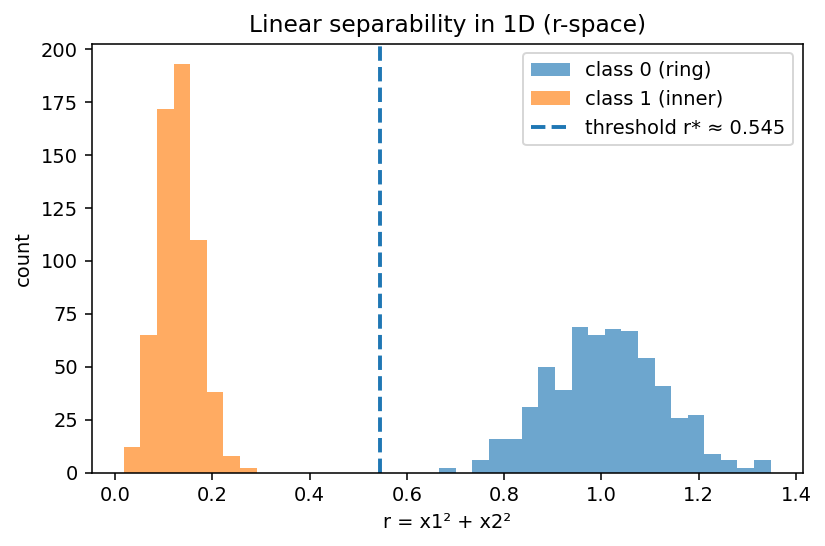

In [4]:
plt.figure(figsize=(6,4), dpi=140)
bins = np.linspace(r.min(), r.max(), 40)
plt.hist(r[y==0], bins=bins, alpha=0.65, label="class 0 (ring)")
plt.hist(r[y==1], bins=bins, alpha=0.65, label="class 1 (inner)")
if r_thresh is not None:
    plt.axvline(r_thresh, linestyle="--", linewidth=2, label=f"threshold r* ≈ {r_thresh:.3f}")
plt.xlabel("r = x1² + x2²"); plt.ylabel("count")
plt.title("Linear separability in 1D (r-space)")
plt.legend(); plt.tight_layout(); plt.show()

## Logistic model in 1D r-space

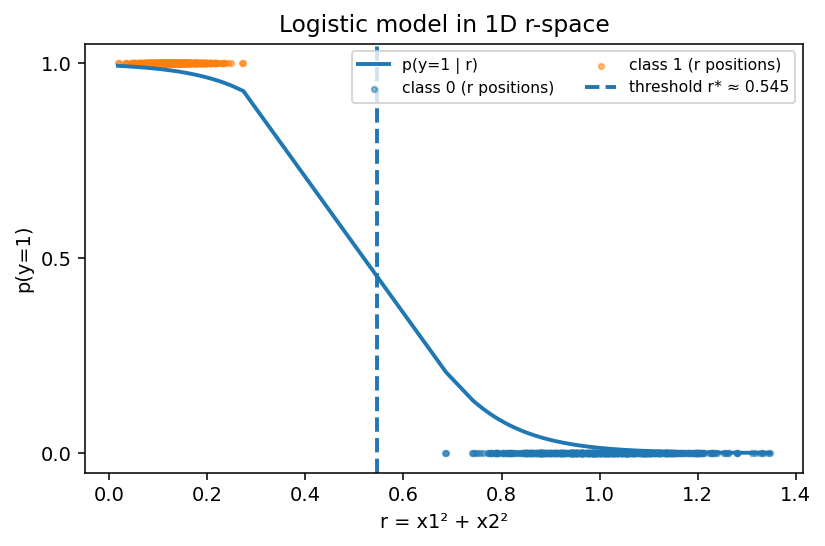

In [5]:
order = np.argsort(r.ravel())
r_sorted = r.ravel()[order]
p_sorted = clf_r.predict_proba(r_sorted.reshape(-1,1))[:,1]

plt.figure(figsize=(6,4), dpi=140)
plt.plot(r_sorted, p_sorted, linewidth=2, label="p(y=1 | r)")
plt.scatter(r[y==0], np.zeros_like(r[y==0]), s=8, alpha=0.5, label="class 0 (r positions)")
plt.scatter(r[y==1], np.ones_like(r[y==1]), s=8, alpha=0.5, label="class 1 (r positions)")
if r_thresh is not None:
    plt.axvline(r_thresh, linestyle="--", linewidth=2, label=f"threshold r* ≈ {r_thresh:.3f}")
plt.yticks([0, 0.5, 1]); plt.ylim(-0.05, 1.05)
plt.xlabel("r = x1² + x2²"); plt.ylabel("p(y=1)")
plt.title("Logistic model in 1D r-space")
plt.legend(loc="best", ncol=2, fontsize=8)
plt.tight_layout(); plt.show()

## Decision boundary from r = x1² + x2² (logistic)

Uses `clf_r.predict_proba` for drawing the decision boundary.

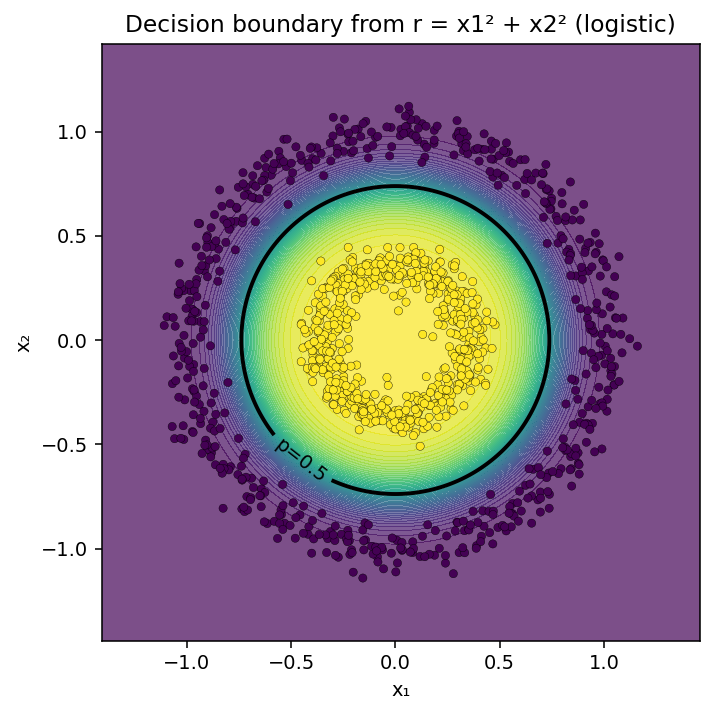

In [6]:
xx, yy = np.meshgrid(
    np.linspace(X[:,0].min()-0.3, X[:,0].max()+0.3, 400),
    np.linspace(X[:,1].min()-0.3, X[:,1].max()+0.3, 400)
)
grid = np.c_[xx.ravel(), yy.ravel()]
r_grid = (grid[:,0]**2 + grid[:,1]**2).reshape(-1,1)
p_r = clf_r.predict_proba(r_grid)[:, 1].reshape(xx.shape)

plt.figure(figsize=(5.2,5.2), dpi=140)
cf = plt.contourf(xx, yy, p_r, levels=50, alpha=0.7)
cs = plt.contour(xx, yy, p_r, levels=[0.5], linewidths=2, colors="k")
plt.scatter(X[:,0], X[:,1], c=y, s=18, edgecolor="k", linewidth=0.2)
plt.clabel(cs, fmt={0.5:"p=0.5"})
plt.title("Decision boundary from r = x1² + x2² (logistic)")
plt.xlabel("x₁"); plt.ylabel("x₂"); plt.tight_layout(); plt.show()

## Decision boundary from quadratic features (logistic)

Uses `quad.predict_proba` for drawing the decision boundary. (Indeed,
the two models produce the same result.)

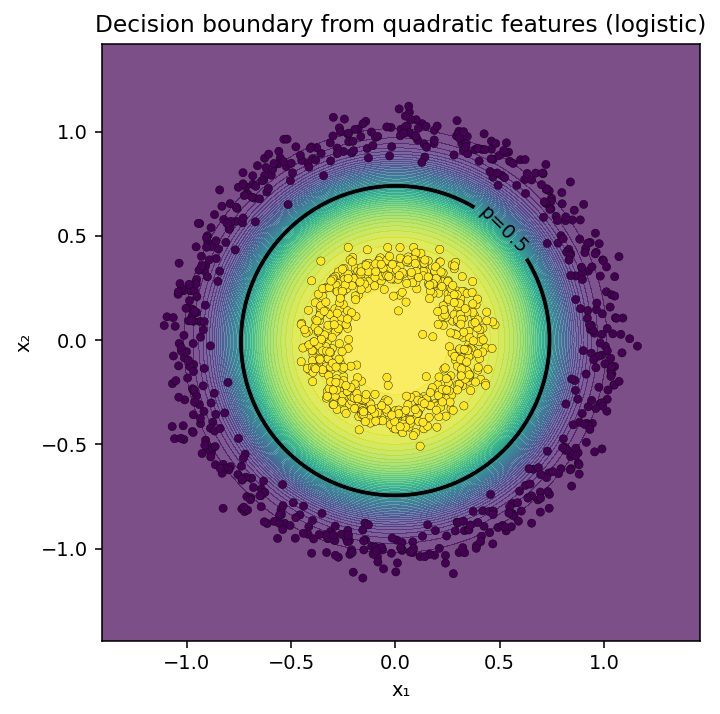

In [7]:
p_quad = quad.predict_proba(grid)[:, 1].reshape(xx.shape)

plt.figure(figsize=(5.2,5.2), dpi=140)
cf = plt.contourf(xx, yy, p_quad, levels=50, alpha=0.7)
cs2 = plt.contour(xx, yy, p_quad, levels=[0.5], linewidths=2, colors="k")
plt.scatter(X[:,0], X[:,1], c=y, s=18, edgecolor="k", linewidth=0.2)
plt.clabel(cs2, fmt={0.5:"p=0.5"})
plt.title("Decision boundary from quadratic features (logistic)")
plt.xlabel("x₁"); plt.ylabel("x₂"); plt.tight_layout(); plt.show()

## Neural network

To further our understanding of neural networks behavior, let’s
configure a model to use only the features $x_1$ and $x_2$. We will set
up two hidden layers, each consisting of four neurons. In my
experiments, the `Tanh` activation function led to rapid network
convergence. The `Sigmoid` function also converged, though at a slower
pace. Meanwhile, the `ReLU` activation function enabled quick
convergence but produced a decision boundary comprised of linear
segments.

In [8]:
from sklearn.model_selection import train_test_split

# Two-layer (4 + 4) Keras MLP on make_circles + decision boundary plot

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# 0) Reproducibility

np.random.seed(42)
tf.random.set_seed(42)

# 1) Data

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

In [9]:
# 2) Model: 2 hidden layers with 4 units each
# tanh works nicely here due to circular symmetry (ReLU is fine too).

model = keras.Sequential([
    layers.Input(shape=(2,)),
    layers.Dense(4, activation="tanh"),
    layers.Dense(4, activation="tanh"),
    layers.Dense(1, activation="sigmoid")
])

In [10]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [11]:
# Optional: early stopping for quick convergence
es = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, monitor="val_loss")

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=300,
    batch_size=64,
    verbose=0,
    callbacks=[es]
)

print(f"Train acc: {history.history['accuracy'][-1]:.3f} | "
      f"Val acc (best): {max(history.history['val_accuracy']):.3f}")

Train acc: 1.000 | Val acc (best): 1.000

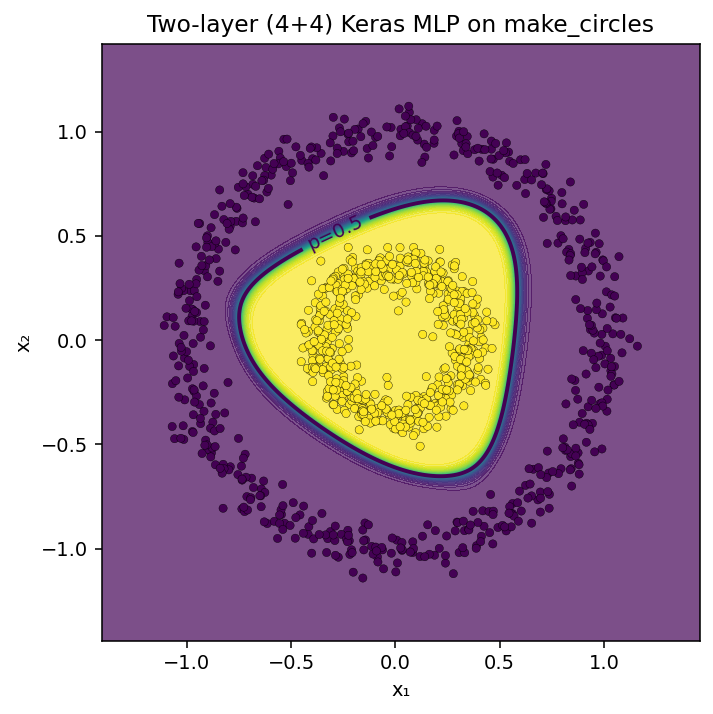

In [12]:
# 3) Plot helper: decision boundary in the original (x1, x2) plane

def plot_decision_boundary(model, X, y, title="Keras MLP decision boundary"):
    # grid over the input plane
    pad = 0.3
    x1_min, x1_max = X[:,0].min()-pad, X[:,0].max()+pad
    x2_min, x2_max = X[:,1].min()-pad, X[:,1].max()+pad
    xx, yy = np.meshgrid(
        np.linspace(x1_min, x1_max, 400),
        np.linspace(x2_min, x2_max, 400)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    # predict probabilities on the grid
    p = model.predict(grid, verbose=0).reshape(xx.shape)

    # filled probabilities + p=0.5 contour + data points
    plt.figure(figsize=(5.2, 5.2), dpi=140)
    plt.contourf(xx, yy, p, levels=50, alpha=0.7)
    cs = plt.contour(xx, yy, p, levels=[0.5], linewidths=2)
    plt.scatter(X[:,0], X[:,1], c=y, s=18, edgecolor="k", linewidth=0.2)
    plt.clabel(cs, fmt={0.5: "p=0.5"})
    plt.title(title)
    plt.xlabel("x₁")
    plt.ylabel("x₂")
    plt.tight_layout()
    plt.show()

plot_decision_boundary(model, X, y, title="Two-layer (4+4) Keras MLP on make_circles")

## XOR dataset

This example uses a classical dataset, characterized by an
“exclusive-or” (XOR) pattern, which is frequently employed to
demonstrate non-linear decision boundaries and to underscore the
necessity of neural networks in addressing such complexities.

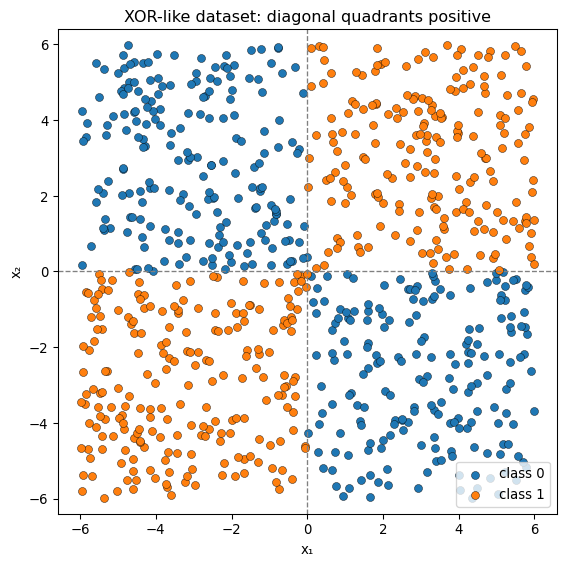

In [13]:
# 1. Generate the XOR dataset

n_samples = 800
rng = np.random.default_rng(42)

# Features uniformly sampled in [-6, 6]
X = rng.uniform(-6, 6, size=(n_samples, 2))
x1, x2 = X[:, 0], X[:, 1]

# Labels: positive if (x1 and x2) have the same sign (top-left or bottom-right)
y = ((x1 * x2) > 0).astype(int)

# 2. Visualize the data

plt.figure(figsize=(6, 6))
plt.scatter(X[y == 0, 0], X[y == 0, 1],
            color="C0", label="class 0", edgecolor="k", linewidth=0.3)
plt.scatter(X[y == 1, 0], X[y == 1, 1],
            color="C1", label="class 1", edgecolor="k", linewidth=0.3)

# Draw axes for clarity
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.axvline(0, color="gray", linestyle="--", linewidth=1)

plt.xlabel("x₁")
plt.ylabel("x₂")
plt.title("XOR-like dataset: diagonal quadrants positive")
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.axis("equal")
plt.legend()
plt.tight_layout()
plt.show()

Would it be reasonable to anticipate that the features engineered for
circular data could be beneficial in this context?

In [14]:
r = (x1**2 + x2**2).reshape(-1, 1)

# Models
clf_r = LogisticRegression().fit(r, y)

quad = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("logreg", LogisticRegression(max_iter=1000))
]).fit(X, y)

# Threshold r* (p=0.5) for the r-only model

w = float(clf_r.coef_[0][0]); b = float(clf_r.intercept_[0])
r_thresh = -b / w if abs(w) > 1e-12 else None

Certainly not!”

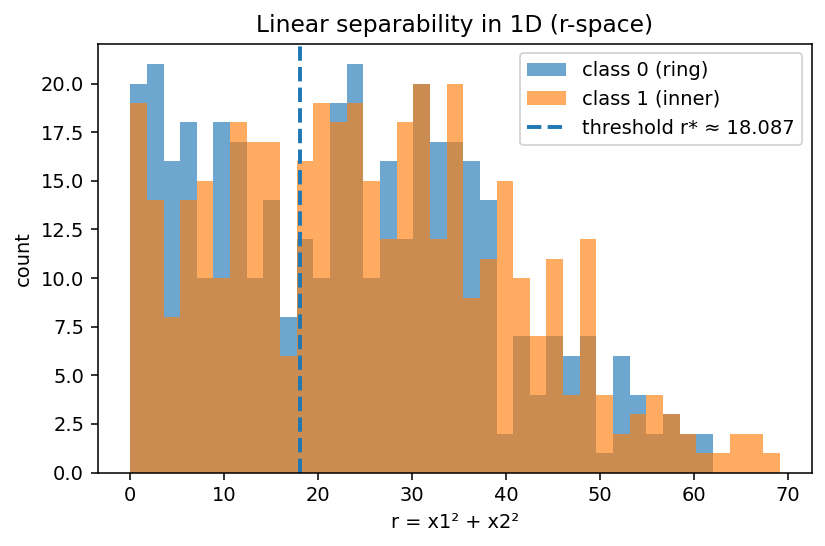

In [15]:
plt.figure(figsize=(6,4), dpi=140)
bins = np.linspace(r.min(), r.max(), 40)
plt.hist(r[y==0], bins=bins, alpha=0.65, label="class 0 (ring)")
plt.hist(r[y==1], bins=bins, alpha=0.65, label="class 1 (inner)")
if r_thresh is not None:
    plt.axvline(r_thresh, linestyle="--", linewidth=2, label=f"threshold r* ≈ {r_thresh:.3f}")
plt.xlabel("r = x1² + x2²"); plt.ylabel("count")
plt.title("Linear separability in 1D (r-space)")
plt.legend(); plt.tight_layout(); plt.show()

To address the problem using logistic regression, it would be necessary
to engineer new features. Can you propose any such features?

What about our neural network model? Can we reasonably expect it to
perform well on this dataset? Below is a verbatim copy of the code.

In [16]:
# 0) Reproducibility

np.random.seed(42)
tf.random.set_seed(42)

# 1) Data

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

In [17]:
# 2) Model: 2 hidden layers with 4 units each
# tanh works nicely here due to circular symmetry (ReLU is fine too).

model = keras.Sequential([
    layers.Input(shape=(2,)),
    layers.Dense(4, activation="tanh"),
    layers.Dense(4, activation="tanh"),
    layers.Dense(1, activation="sigmoid")
])

In [18]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [19]:
# Optional: early stopping for quick convergence
es = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, monitor="val_loss")

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=300,
    batch_size=64,
    verbose=0,
    callbacks=[es]
)

print(f"Train acc: {history.history['accuracy'][-1]:.3f} | "
      f"Val acc (best): {max(history.history['val_accuracy']):.3f}")

Train acc: 1.000 | Val acc (best): 0.990

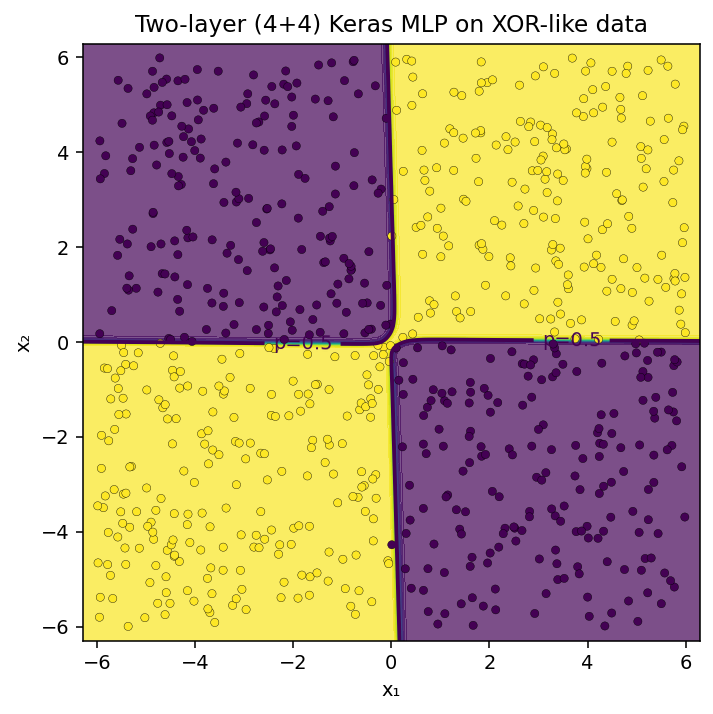

In [20]:
# 3) Plot helper: decision boundary in the original (x1, x2) plane

def plot_decision_boundary(model, X, y, title="Keras MLP decision boundary"):
    # grid over the input plane
    pad = 0.3
    x1_min, x1_max = X[:,0].min()-pad, X[:,0].max()+pad
    x2_min, x2_max = X[:,1].min()-pad, X[:,1].max()+pad
    xx, yy = np.meshgrid(
        np.linspace(x1_min, x1_max, 400),
        np.linspace(x2_min, x2_max, 400)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    # predict probabilities on the grid
    p = model.predict(grid, verbose=0).reshape(xx.shape)

    # filled probabilities + p=0.5 contour + data points
    plt.figure(figsize=(5.2, 5.2), dpi=140)
    plt.contourf(xx, yy, p, levels=50, alpha=0.7)
    cs = plt.contour(xx, yy, p, levels=[0.5], linewidths=2)
    plt.scatter(X[:,0], X[:,1], c=y, s=18, edgecolor="k", linewidth=0.2)
    plt.clabel(cs, fmt={0.5: "p=0.5"})
    plt.title(title)
    plt.xlabel("x₁")
    plt.ylabel("x₂")
    plt.tight_layout()
    plt.show()

plot_decision_boundary(model, X, y, title="Two-layer (4+4) Keras MLP on XOR-like data")

Pretty impressive, don’t you think?

The key takeaway is that feature engineering combined with basic machine
learning models can yield satisfactory results, especially in
straightforward scenarios like those illustrated here. When data
visualization is feasible or when domain expertise is available, this
process is generally accessible. However, in more complex situations
involving hundreds or thousands of features and intricate domains,
neural networks are particularly effective. Their capability to learn
hierarchical representations of features allows them to excel in these
challenging contexts.